# Block model using `SimPEG`



In [1]:
# core python libraries we rely on
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import time
from datetime import datetime
  
# SimPEG ecosystem 
import discretize
from discretize.utils import mkvc
import SimPEG
from SimPEG.electromagnetics import frequency_domain as fdem
from pymatsolver import Pardiso
import ipywidgets
%load_ext memory_profiler

## load the model and survey

In [3]:
# 1D background
depth = [0., -600, -850, -3150]
res1d = [1e8, 0.3, 1, 2, 1000]
aniso = [1, 1, 1, np.sqrt(2), 1]

# Define dimensions of the three blocks [x1, x2, y1, y2, z1, z2]
block1 = [ -500,  500, -4000, 4000,  -1600, -850]
block2 = [    0, 5000, -3000,    0,  -1850, -1600]
block3 = [-5000,    0,     0, 3000, -2900, -1600]

# Resistivities Block 1, 2, and 3
resistivities = [10, 100, 500]

In [4]:
ds = xr.load_dataset('../block_model_and_survey.nc', engine='h5netcdf')

In [5]:
# Get Survey
src = ds.attrs['src']
strength = ds.attrs['strength']
freq = ds.attrs['freq']
rec_x = ds.x.data[::2]
rec_y = ds.attrs['rec_y']
rec_z = ds.attrs['rec_z']
rx_locs = discretize.utils.ndgrid([rec_x, rec_y, np.r_[rec_z]])

# Get source center (for meshing)
src_c = np.mean(src.reshape(-1, 2), 1)
print(src)

[-100.  100.    0.    0. -550. -550.]


In [6]:
print(
    f"skin depth: {503/np.sqrt(freq/np.unique(res1d))}"
)

skin depth: [2.75504446e+02 5.03000000e+02 7.11349422e+02 1.59062566e+04
 5.03000000e+06]


## create a computational mesh

Start by defining the underlying tensor mesh

In [7]:
mesh_b = discretize.load_mesh("./emg3d_tensor_mesh.json")

In [8]:
mesh_b

TensorMesh: 1,572,864 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    256    -57,087.78     65,201.21    100.00  8,113.42    1.17
   y     64    -51,967.77     51,967.77    200.00 14,623.87    1.43
   z     96    -35,514.71     65,482.02     50.00 19,403.13    1.42

(<matplotlib.collections.QuadMesh at 0x7f45d3c2ea00>,
 <matplotlib.lines.Line2D at 0x7f45d3c2eeb0>)

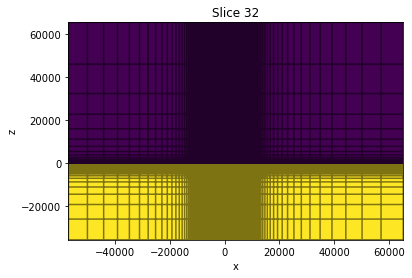

In [9]:
mesh_b.plotSlice(mesh_b.gridCC[:,2]<0., normal='Y', grid=True)

### put the model on the computational mesh

In [10]:
def build_model(mesh):
    rhoh = np.ones(mesh.nC) * res1d[-1]
    rhov = np.ones(mesh.nC) * res1d[-1] *aniso[-1]
    for ii in [3, 2, 1, 0]:
        inds = mesh.gridCC[:,2]>depth[ii]
        rhoh[inds] = res1d[ii]
        rhov[inds] = res1d[ii] *aniso[ii]**2
    
    for r, b in zip(resistivities, [block1, block2, block3]):
        inds = (
            (mesh.gridCC[:, 0] >= b[0]) & (mesh.gridCC[:, 0] <= b[1]) &
            (mesh.gridCC[:, 1] >= b[2]) & (mesh.gridCC[:, 1] <= b[3]) &
            (mesh.gridCC[:, 2] >= b[4]) & (mesh.gridCC[:, 2] <= b[5])
        )
        rhoh[inds] = r
        rhov[inds] = r
            
    return rhoh, rhov

In [11]:
rhoh_b, rhov_b = build_model(mesh_b)

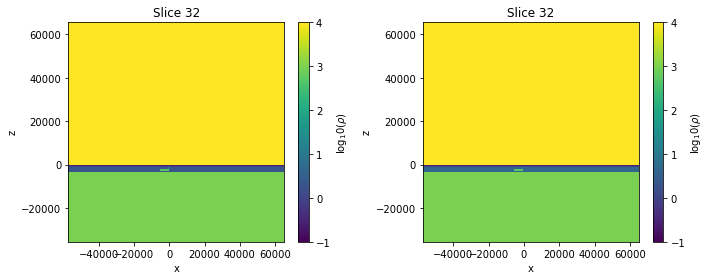

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ii = 3
for a, m, mesh in zip(
    ax.flatten(), 
    [rhoh_b, rhov_b], #rhoh_t, rhov_t], 
    [mesh_b, mesh_b], #mesh_t, mesh_t]
):
    cb = plt.colorbar(
        mesh.plotSlice(np.log10(m), ax=a, normal='Y', clim=(-1, 4))[0], ax=a
    )
    cb.set_label("log$_10$($\\rho$)")

plt.tight_layout()

In [13]:
rho_b = np.vstack([rhoh_b, rhoh_b, rhov_b]).T

## set up the frequency domain simulation

In [14]:
rx_re = fdem.receivers.Point_e(locations=rx_locs, orientation="x", component="real")
rx_im = fdem.receivers.Point_e(locations=rx_locs, orientation="x", component="imag")

In [15]:
def build_source(mesh): 
    src_x = np.zeros(mesh.nEx)
    src_inds = (
        (mesh.gridEx[:, 0] >= src[0] - 1) & (mesh.gridEx[:, 0] <= src[1] + 1) &
        (mesh.gridEx[:, 1] >= src[2] - 1) & (mesh.gridEx[:, 1] <= src[3] + 1) &
        (mesh.gridEx[:, 2] >= src[4] - 1) & (mesh.gridEx[:, 2] <= src[5] + 1) 
    )
    src_x[src_inds] = 1
    print(src_inds.nonzero())

    src_vec = strength * mesh.edge * np.hstack([
        src_x, np.zeros(mesh.nEy), np.zeros(mesh.nEz)
    ])
    source = fdem.sources.RawVec_e(s_e=src_vec, freq=freq, receiver_list=[rx_re, rx_im])
    return source

In [16]:
strength

800.0

In [17]:
source_b = build_source(mesh_b)

(array([1123198, 1123199, 1123200]),)


In [18]:
survey_b = fdem.Survey([source_b])

In [19]:
sim_b = fdem.Simulation3DElectricField(
    mesh=mesh_b, solver=Pardiso, survey=survey_b, rho=rho_b
)

In [20]:
%%time
t0 = time.time()
mem_b = %memit -o fields_b = sim_b.fields()
time_b = time.time()-t0
ram_b = f"{(mem_b.mem_usage[0] - mem_b.baseline)/1024:.3f} GiB"
print(f"memory usage: {ram_b}")

peak memory: 287799.80 MiB, increment: 287320.56 MiB
memory usage: 280.586 GiB
CPU times: user 10h 45min, sys: 4min 3s, total: 10h 49min 3s
Wall time: 2h 46min 33s


In [21]:
np.save("simpeg_block_tensor_fields.npy", fields_b[:, 'e'])

In [22]:
# from scipy import interpolate 

In [23]:
# n_data_locs = rx_re.locs.shape[0]
# data_re_rbf = np.zeros(n_data_locs)
# data_im_rbf = np.zeros(n_data_locs)

# ncells_interp = 4 
# dx_interp = ncells_interp * dx
# dy_interp = ncells_interp * dy
# dz_interp = ncells_interp * dz

# ex = fields_b[:, "e"][:mesh_b.nEx]

# for i in range(n_data_locs):
#     inds = (
#         (mesh_b.gridEx[:, 0] >= rx_re.locs[i, 0] - dx_interp) & 
#         (mesh_b.gridEx[:, 0] <= rx_re.locs[i, 0] + dx_interp) &
#         (mesh_b.gridEx[:, 1] >= rx_re.locs[i, 1] - dy_interp) & 
#         (mesh_b.gridEx[:, 1] <= rx_re.locs[i, 1] + dy_interp) &
#         (mesh_b.gridEx[:, 2] >= rx_re.locs[i, 2] - dz_interp) & 
#         (mesh_b.gridEx[:, 2] <= rx_re.locs[i, 2] + dz_interp) 
#     )
    
#     grid = mesh_b.gridEx[inds, :]
#     ex_re = ex[inds].real
#     ex_im = ex[inds].imag
    
#     rbf_re = interpolate.Rbf(grid[:, 0], grid[:, 1], grid[:, 2], ex_re) #, function="cubic")
#     rbf_im = interpolate.Rbf(grid[:, 0], grid[:, 1], grid[:, 2], ex_im) #, function="cubic")
    
#     data_re_rbf[i] = rbf_re(rx_re.locs[i, 0], rx_re.locs[i, 1], rx_re.locs[i, 2])
#     data_im_rbf[i] = rbf_im(rx_re.locs[i, 0], rx_re.locs[i, 1], rx_re.locs[i, 2])
# d_b_rbf = np.hstack([data_re_rbf, data_im_rbf])

In [24]:
d_b = sim_b.dpred(f=fields_b)  # this uses linear interpolation 

In [25]:
# reshape data to desired shape

def get_data_lines(data): 
    d_re = data[:rx_locs.shape[0]]
    d_im = data[rx_locs.shape[0]:]

    d_line1 = 1/1.5 * np.vstack([d_re[:101], d_im[:101]]).T
    d_line2 = 1/1.5 * np.vstack([d_re[101:202], d_im[101:202]]).T
    d_line3 = 1/1.5 * np.vstack([d_re[202:], d_im[202:]]).T
    #1.5 is due to the length of the bipole
    return [d_line1, d_line2, d_line3]

data_b_lines = get_data_lines(d_b)

In [34]:
spg_data_t = np.vstack([d[:, 0] + 1j*d[:, 1] for d in data_b_lines]).T


In [26]:
def extract_lines(name):
    import xarray as xr
    inp = xr.load_dataset(name, engine='h5netcdf')
    out = np.stack([
        inp.line_1[::2]+1j*inp.line_1[1::2],
        inp.line_2[::2]+1j*inp.line_2[1::2],
        inp.line_3[::2]+1j*inp.line_3[1::2],
    ]).T
    return out

epm_1d = extract_lines('../results/layered_empymod.nc')

In [27]:
def get_pos_neg(resp, off, min_off):
    """Separate positive and negative values, enforce min_off."""
    resp_pos = np.array([x if x > 0 else np.nan for x in resp])
    resp_neg = np.array([-x if x < 0 else np.nan for x in resp])

    resp_pos[off < min_offset] = np.nan
    resp_neg[off < min_offset] = np.nan

    return resp_pos, resp_neg

### Compare results

In [35]:
egd_tg = extract_lines('../results/block_emg3d.nc')
ptg_tg = extract_lines('../results/block_petgem.nc')
cst_tg = extract_lines('../results/block_custEM_p2.nc')
spg_tg = spg_data_t

In [36]:
# Collect data
data = {'emg3d': egd_tg, 'custEM': cst_tg, 'PETGEM': ptg_tg, 'SimPEG': spg_tg}

In [37]:
# Calculate normalized difference
diff = {}
ndiff = {}
for name, data1, data2 in zip(['emg3d-custEM', 'custEM-PETGEM', 'SimPEG-emg3d'],
                              [egd_tg, cst_tg, spg_tg],
                              [cst_tg, ptg_tg, egd_tg],
                              ):
    
    diff[name] = (abs(data1.real - data2.real) + 1j*abs(data1.imag - data2.imag))
    rndiff = np.clip(200*abs(data1.real - data2.real) /
                     (abs(data1.real) + abs(data2.real)), 0.01, 100)
    indiff = np.clip(200*abs(data1.imag - data2.imag) /
                     (abs(data1.imag) + abs(data2.imag)), 0.01, 100)
    ndiff[name] = rndiff + 1j*indiff

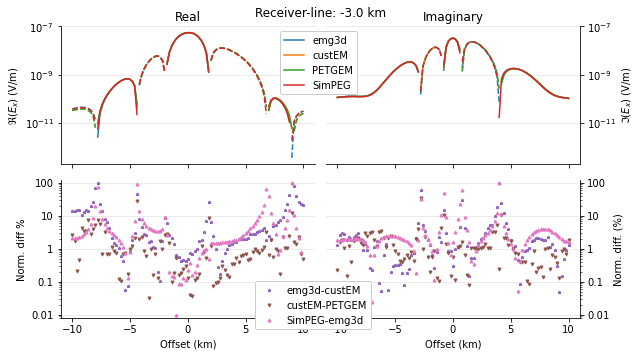

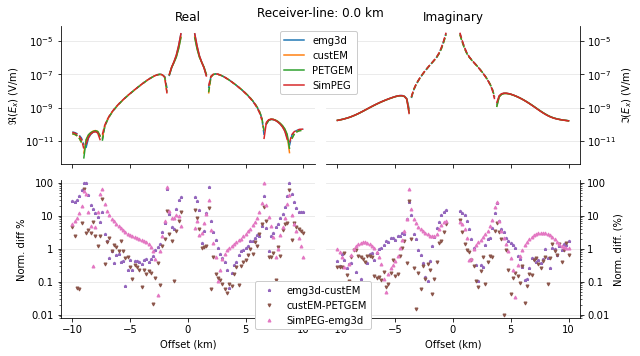

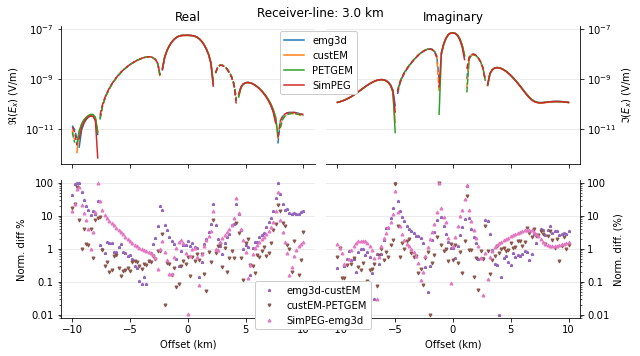

In [38]:
marker = ['*', 'v', '^', 'o']
min_offset = 500

for iy, y in enumerate(rec_y):
    
    # Get offset
    off = np.sqrt(rec_x**2 + y**2)

    plt.figure(figsize=(9, 5))

    # # Real
    ax1 = plt.subplot(221)
    plt.title('Real')

    for i, name in enumerate(data.keys()):
        resp_pos, resp_neg = get_pos_neg(data[name][:, iy].real, off, min_offset)
        plt.plot(rec_x/1e3, resp_pos, f'C{i}-', ms=3, label=name)
        plt.plot(rec_x/1e3, resp_neg, f'C{i}--', ms=3)

    plt.ylabel(r'$\Re(E_x)$ (V/m)')
    ax1.set_xticklabels([])
    plt.grid(axis='y', c='0.9')


    # # Real normalized difference
    ax2 = plt.subplot(223)

    for i, name in enumerate(ndiff.keys()):
        ndiff[name][off < min_offset, iy] = np.nan + 1j*np.nan
        plt.plot(rec_x/1e3, ndiff[name][:, iy].real, f'C{i+4}{marker[i]}', ms=3, label=name)

    plt.yscale('log')
    plt.xlim(ax1.get_xlim())
    plt.ylabel('Norm. diff %')
    plt.ylim([8e-3, 120])
    plt.yticks([0.01, 0.1, 1, 10, 100], ('0.01', '0.1', '1', '10', '100'))
    plt.grid(axis='y', c='0.9')
    plt.xlabel('Offset (km)')


    # # Imaginary
    ax3 = plt.subplot(222, sharey=ax1)
    plt.title('Imaginary')

    for i, name in enumerate(data.keys()):
        resp_pos, resp_neg = get_pos_neg(data[name][:, iy].imag, off, min_offset)
        plt.plot(rec_x/1e3, resp_pos, f'C{i}-', ms=3, label=name)
        plt.plot(rec_x/1e3, resp_neg, f'C{i}--', ms=3)
    
    plt.yscale('log')
    plt.ylabel(r'$\Im(E_x)$ (V/m)')

    ax3.set_xticklabels([])
    ax3.yaxis.tick_right()
    ax3.yaxis.set_label_position("right")
    plt.grid(axis='y', c='0.9')


    # # Imaginary normalized difference
    ax4 = plt.subplot(224, sharey=ax2)

    for i, name in enumerate(ndiff.keys()):
        plt.plot(rec_x/1e3, ndiff[name][:, iy].imag, f'C{i+4}{marker[i]}', ms=3, label=name)

    plt.yscale('log')
    plt.xlim(ax1.get_xlim())
    plt.xlabel('Offset (km)')
    plt.ylabel('Norm. diff. (%)')
    plt.ylim([8e-3, 120])
    plt.yticks([0.01, 0.1, 1, 10, 100], ('0.01', '0.1', '1', '10', '100'))
    ax4.yaxis.tick_right()
    ax4.yaxis.set_label_position("right")
    plt.grid(axis='y', c='0.9')

    # Switch off spines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.spines['left'].set_visible(False)

    plt.tight_layout()
    plt.sca(ax3)
    plt.legend(loc=2, bbox_to_anchor=(-0.2, 1), framealpha=1)
    plt.sca(ax4)
    plt.legend(loc=2, bbox_to_anchor=(-0.3, 0.3), framealpha=1)

    #plt.savefig(f'../manuscript/figures/results-block-{int(y/1e3)}.pdf', bbox_inches='tight')
    plt.suptitle(f'Receiver-line: {y/1e3} km')
    plt.show()

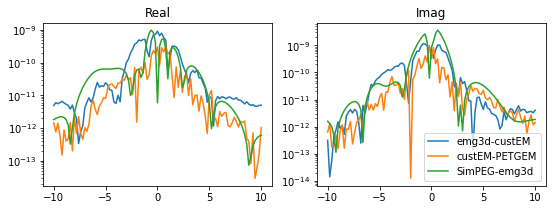

In [39]:
plt.figure(figsize=(9, 3))

# # Real
ax1 = plt.subplot(121)
plt.title('Real')

for i, name in enumerate(diff.keys()):
    resp_pos, resp_neg = get_pos_neg(diff[name][:, iy].real, off, min_offset)
    plt.plot(rec_x/1e3, resp_pos, f'C{i}-', ms=3, label=name)
    plt.plot(rec_x/1e3, resp_neg, f'C{i}--', ms=3)
    plt.yscale('log')
    
ax2 = plt.subplot(122)
plt.title('Imag')

for i, name in enumerate(diff.keys()):
    resp_pos, resp_neg = get_pos_neg(diff[name][:, iy].imag, off, min_offset)
    plt.plot(rec_x/1e3, resp_pos, f'C{i}-', ms=3, label=name)
    plt.plot(rec_x/1e3, resp_neg, f'C{i}--', ms=3)
    plt.yscale('log')

ax2.legend()

In [40]:
save_results = True

In [41]:
if save_results: 
    # Save the three lines
    ds.line_1.data = np.vstack([spg_data_t[:, 0].real, spg_data_t[:, 0].imag]).ravel('F')
    ds.line_2.data = np.vstack([spg_data_t[:, 1].real, spg_data_t[:, 1].imag]).ravel('F')
    ds.line_3.data = np.vstack([spg_data_t[:, 2].real, spg_data_t[:, 2].imag]).ravel('F')

    # Add info
    ds.attrs['runtime'] = time_b
    ds.attrs['n_procs'] = 1
    ds.attrs['max_ram'] = ram_b
    ds.attrs['n_cells'] = f"{mesh_b.nC}"
    ds.attrs['n_nodes'] = 'N/A'
    ds.attrs['n_dof'] = f"{mesh.nE}"
    ds.attrs['extent'] = (f"x = {mesh_b.vectorNx[0]:.1f}-{mesh_b.vectorNx[-1]:.1f}; " # Total mesh extent
                          f"y = {mesh_b.vectorNy[0]:.1f}-{mesh_b.vectorNy[-1]:.1f}; "
                          f"z = {mesh_b.vectorNz[0]:.1f}-{mesh_b.vectorNz[-1]:.1f}")
    ds.attrs['min_vol'] = f"{np.min(mesh_b.vol):.1f}"
    ds.attrs['max_vol'] = f"{np.max(mesh_b.vol):.1f}"
    ds.attrs['machine'] = "GKE n2-custom (8 vCPUs, 355 GB memory); Intel Cascade Lake; Ubuntu-1604-xenial"
    ds.attrs['version'] = f"SimPEG v{SimPEG.__version__}"
    ds.attrs['date'] = datetime.today().isoformat()

    # Save it under <{model}_{code}.nc>
    ds.to_netcdf(f"../results/block_simpeg_tensor.nc", engine='h5netcdf')

NameError: name 'spg_data' is not defined

In [ ]:
# ds

In [ ]:
# # Save the three lines
# ds.line_1.data = np.vstack([spg_data_t[:, 0].real, spg_data_t[:, 0].imag]).ravel('F')
# ds.line_2.data = np.vstack([spg_data_t[:, 1].real, spg_data_t[:, 1].imag]).ravel('F')
# ds.line_3.data = np.vstack([spg_data_t[:, 2].real, spg_data_t[:, 2].imag]).ravel('F')

# # Add info
# ds.attrs['runtime'] = time_t
# ds.attrs['n_procs'] = 1
# ds.attrs['max_ram'] = ram_t
# ds.attrs['n_cells'] = f"{mesh_t.nC}"
# ds.attrs['n_nodes'] = 'N/A'
# ds.attrs['n_dof'] = f"{mesh.nE}"
# ds.attrs['extent'] = (f"x = {mesh_t.vectorNx[0]:.1f}-{mesh_t.vectorNx[-1]:.1f}; " # Total mesh extent
#                       f"y = {mesh_t.vectorNy[0]:.1f}-{mesh_t.vectorNy[-1]:.1f}; "
#                       f"z = {mesh_t.vectorNz[0]:.1f}-{mesh_t.vectorNz[-1]:.1f}")
# ds.attrs['min_vol'] = f"{np.min(mesh_t.vol):.1f}"
# ds.attrs['max_vol'] = f"{np.max(mesh_t.vol):.1f}"
# ds.attrs['machine'] = "Cheyenne Supercomputer - shared node; Intel(R) Xeon(R) CPU E5-2697 v4 @ 2.30GHz"
# ds.attrs['version'] = f"SimPEG v{SimPEG.__version__}"
# ds.attrs['date'] = datetime.today().isoformat()

# # Save it under <{model}_{code}.nc>
# ds.to_netcdf(f"../results/block_simpeg.nc", engine='h5netcdf')